# 9-3. 고급 순환층

SimpleRNN은 긴 시퀀스 학습이 어렵고 시퀀스가 길수록 순환되는 은닉상태에 담긴 정보가 점차 희석된다. 따라서 멀리 떨어진 단어 정보 인식에 어려움이 있다.

# LSTM 구조

Long Short-Term Memory의 약자. 단기 기억을 오래 기억하기 위해 고안

* LSTM의 은닉상태

입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수 통과시켜 은닉상태를 만든다. 기본 순환층과 달리 시그모이드 활성화 함수를 사용하며 tnah 활성화 함수를 통과한 어떤 값과 곱해져 은닉을 만든다.

* 셀 상태(cell state)

은닉과 구분되는 순환되는 상태 중 하나로 은닉 상태와 달리 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 하는 값  

셀 상태는 이전 타임스텝의 셀 상태와 곱하여 만들어진다. 이 셀 상태가 tanh함수를 통과하여 새로운 은닉상태를 만든다.


# LSTM 신경망 훈련하기



In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [1]:
# 훈련세트 검증세트 테스트세트 분리

from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [2]:
# 패딩추가

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [3]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


SimpleRNN은 모델 파라미터가 200개였다.  
LSTM 셀에는 작은 셀이 4개 있으므로 정확히 4배 늘어 모델의 파라미터 개수가 800개가 된다.

In [4]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 21ms/step - loss: 0.6924 - accuracy: 0.5387 - val_loss: 0.6913 - val_accuracy: 0.5744
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6900 - accuracy: 0.5941 - val_loss: 0.6879 - val_accuracy: 0.6214
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6837 - accuracy: 0.6395 - val_loss: 0.6772 - val_accuracy: 0.6612
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6532 - accuracy: 0.6840 - val_loss: 0.6150 - val_accuracy: 0.6964
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5938 - accuracy: 0.7097 - val_loss: 0.5818 - val_accuracy: 0.7186
Epoch 6/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5655 - accuracy: 0.7320 - val_loss: 0.5587 - val_accuracy: 0.7350
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5426 - accuracy: 0.7534 - val_loss: 0.5385 - val_accuracy:

### 손실 그래프

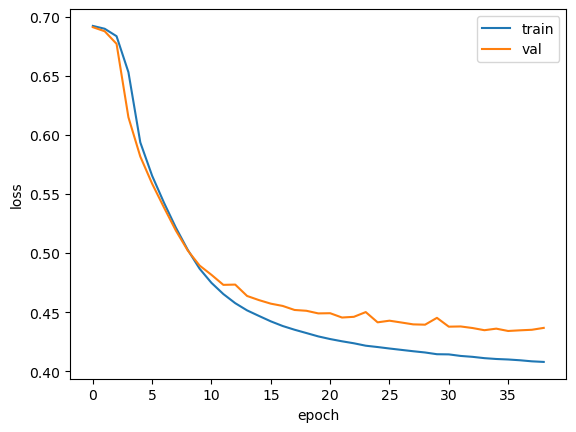

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 순환층에 드롭아웃 적용

훈련 세트 과대 적합을 막는 드롭아웃. 순환층은 자체적 드롭아웃 기능 제공.  
dropout 매개변수는 셀 입력에 드롭 아웃 적용하고 recurrent_dropout은 순환되는 은닉상태에 드롭 아웃 적용. recurrent_dropout의 경우 GPU를 사용하여 모델 훈련 불가하여 훈련 속도가 크게 느려진다. 따라서 해당 예제에서는 dropout만 사용해보도록 한다.

In [6]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3)) # 드롭아웃 추가
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 22ms/step - loss: 0.6928 - accuracy: 0.5180 - val_loss: 0.6923 - val_accuracy: 0.5418
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6916 - accuracy: 0.5691 - val_loss: 0.6908 - val_accuracy: 0.5900
Epoch 3/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6892 - accuracy: 0.6108 - val_loss: 0.6873 - val_accuracy: 0.6344
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6835 - accuracy: 0.6405 - val_loss: 0.6776 - val_accuracy: 0.6348
Epoch 5/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6640 - accuracy: 0.6521 - val_loss: 0.6381 - val_accuracy: 0.6988
Epoch 6/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6179 - accuracy: 0.7112 - val_loss: 0.5993 - val_accuracy: 0.7234
Epoch 7/100
313/313 [==============================] - 6s 21ms/step - loss: 0.5932 - accuracy: 0.7261 - val_loss: 0.5802 - val_accuracy:

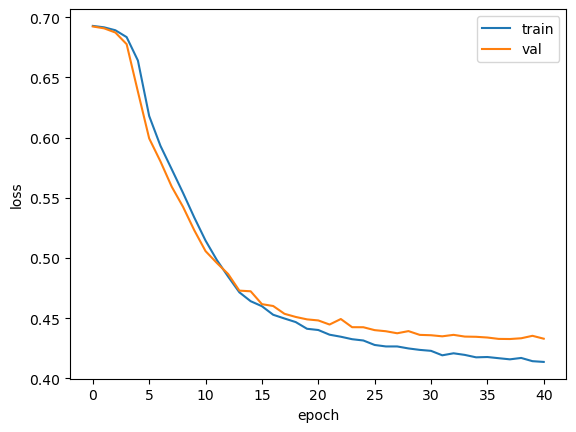

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실과 검증 손실 차이가 좁혀진 것을 확인.

## 2개의 층 연결하기

연결할 시 주의점은 순환층을 쌓게되면 모든 순환층에 순차데이터가 필요해서 앞쪽 순환층이 모든 타임스텝에 대한 은닉상태를 출력해야한다. 또 마지막 순환층만이 마지막 타임스텝의 은닉상태를 출력해야한다. -> 이해가 잘 안됨.

In [9]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


첫번째 LSTM층이 모든 타임스텝(100개)의 은닉 상태를 출력하기 때문에 출력 크기가 (None,100,8)로 표시됨. 반면 두번째 층은 출력크기가 마지막 타임스텝의 은닉상태만 출력 하여 (None,8)이다.

In [10]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 15s 39ms/step - loss: 0.6925 - accuracy: 0.5289 - val_loss: 0.6917 - val_accuracy: 0.5536
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6832 - accuracy: 0.6024 - val_loss: 0.6623 - val_accuracy: 0.6552
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6319 - accuracy: 0.6668 - val_loss: 0.6057 - val_accuracy: 0.6906
Epoch 4/100
313/313 [==============================] - 12s 38ms/step - loss: 0.5878 - accuracy: 0.7027 - val_loss: 0.5616 - val_accuracy: 0.7294
Epoch 5/100
313/313 [==============================] - 12s 39ms/step - loss: 0.5522 - accuracy: 0.7339 - val_loss: 0.5317 - val_accuracy: 0.7456
Epoch 6/100
313/313 [==============================] - 12s 38ms/step - loss: 0.5251 - accuracy: 0.7503 - val_loss: 0.5110 - val_accuracy: 0.7590
Epoch 7/100
313/313 [==============================] - 12s 38ms/step - loss: 0.5071 - accuracy: 0.7620 - val_loss: 0.4930 - val_ac

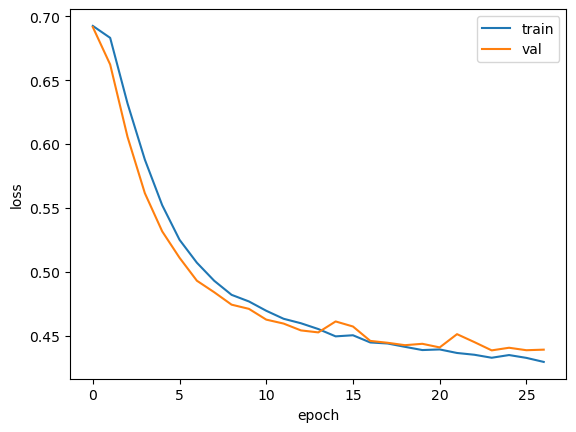

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대 적합을 제어하며 손실을 최대한 낮춤.

# GRU 신경망 훈련하기

* GRU(Gated Recurrent Unit)의 셀은 LSTM을 간소한 버전으로 셀 상태를 계산하지 않고 은닉 상태만 포함하고 있다.  

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀 3개가 들어있음. 셀 2개에는 시그모이드 활성화 함수를 사용하고, 하나는 tanh 활성화 함수를 사용. -> **잘 모르겠음**

LSTM보다 사용하는 가중치가 적어 계산량이 적지만 성능은 LSTM못지 않다는 장점. 

# GRU 신경망 훈련하기

In [12]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


모델 파라미터 개수 - GRU셀에는 3개에 작은 셀이 있음.

입력에 곱하는 가중치는 16 x 8 = `128개`  
은닉 상태에 곱하는 가중치는 8x8 = `64개`  
절편은 뉴런마다 하나씩이므로 절편 `8개`  
모두 더하면 200개 도출

작은 셀이 3개이므로 600개의 모델 파라미터 필요.

실제 모델에서 모델 파라미터의 개수가 24개 더 많은 것은 텐서플로가 GPU를 잘 사용하기 위한 계산방법에 의한 모델 파라미터.(이론과 구현의 차이점)

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 22ms/step - loss: 0.6928 - accuracy: 0.5175 - val_loss: 0.6924 - val_accuracy: 0.5364
Epoch 2/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6911 - accuracy: 0.5629 - val_loss: 0.6906 - val_accuracy: 0.5512
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6889 - accuracy: 0.5768 - val_loss: 0.6881 - val_accuracy: 0.5680
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6855 - accuracy: 0.5924 - val_loss: 0.6848 - val_accuracy: 0.5816
Epoch 5/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6805 - accuracy: 0.6064 - val_loss: 0.6788 - val_accuracy: 0.6016
Epoch 6/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6727 - accuracy: 0.6166 - val_loss: 0.6705 - val_accuracy: 0.6114
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6610 - accuracy: 0.6339 - val_loss: 0.6570 - val_accuracy:

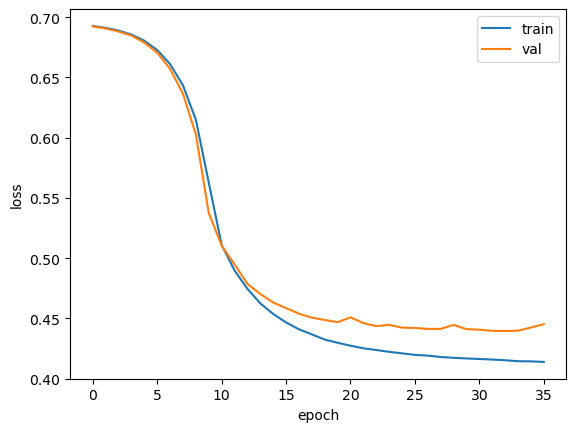

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()